In [1]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from IPython.display import display, HTML
import matplotlib

## Fetch data from server

Run `bin/fetch_data.py <VERSION>`, where VERSION can be found in config.txt.

Data will be saved in `human_raw`, and then interpretted in `human`.

In [2]:
# N.B. all hacky and done quickly
version = '1.3'
load_dir = '../data/human/{}'.format(version)
save_dir = load_dir
print(os.listdir(load_dir))


['html-button-response_processed_1.3.csv', 'processed_data_set_level_1.3.p', 'html-button-response_processed.csv', 'participants.csv', 'processed_data_exp_level_1.3.p', 'html-button-response.csv', 'exclusion_data_1.3.csv', 'survey-multi-select.csv', 'html-keyboard-response.csv', 'processed_data_1.3.p', 'demographics.csv']


In [3]:
responses = pd.read_csv("{}/html-button-response.csv".format(load_dir), index_col=0, squeeze=True)
surveys = pd.read_csv("{}/survey-multi-select.csv".format(load_dir), index_col=0, squeeze=True)
wids = set(responses.wid.tolist())

responses

,stimulus,response,trial_type,time_elapsed,task,question_order,wid
rt,,,,,,,
NaN,"\n <div>\n <img src=""sta...",NaN,html-button-response,160134,test_watch,NaN,w0e1d2bf
5135.9,"\n <div>\n <img src=""sta...",4.0,html-button-response,165272,test_respond,NaN,w0e1d2bf
NaN,"\n <div>\n <img src=""sta...",NaN,html-button-response,166278,test_watch,NaN,w0e1d2bf
2949.4,"\n <div>\n <img src=""sta...",4.0,html-button-response,169230,test_respond,NaN,w0e1d2bf
NaN,"\n <div>\n <img src=""sta...",NaN,html-button-response,170234,test_watch,NaN,w0e1d2bf
...,...,...,...,...,...,...,...
2807.5,"\n <div>\n <img src=""sta...",2.0,html-button-response,364671,test_respond,NaN,w5105a98
NaN,"\n <div>\n <img src=""sta...",NaN,html-button-response,365676,test_watch,NaN,w5105a98
5620.6,"\n <div>\n <img src=""sta...",1.0,html-button-response,371298,test_respond,NaN,w5105a98


In [4]:
def preprocess_trial_data(df):
    """Just print out stimuli, RT, decision for each participant."""
    df2 = df[df['task'] == 'test_respond']
    df2 = df2.reset_index()
    df2 = df2[['wid', 'rt','stimulus', 'response', 'question_order']]
    for i, r in df2.iterrows():
        temp_stim = r[2]
        temp_stim_list = temp_stim.split('images/')
        image_1 = temp_stim_list[1][:3]
        image_2 = temp_stim_list[2][:3]
        df2.iloc[i, 2] = '{} vs {}'.format(image_1, image_2)
        df2.iloc[i, -1] = temp_stim_list[1][2]
    df2 = df2.rename({'question_order': 'stimulus_set'}, axis='columns')
    return df2

def preprocess_participant_data(df, total_responses = 48):
    wids = list(set(df['wid']))
    data = []
    for wid in wids:
        dfTemp = df[df['wid']==wid]
        tempResponses = np.bincount(np.int_(dfTemp['response'][~np.isnan(dfTemp['response'])]),
                                   minlength=9)
        exclude_counts = (tempResponses > np.floor(0.9 * total_responses)).any()
        timeResponses = dfTemp['time_elapsed'][~np.isnan(dfTemp['response'])]
        time = max(timeResponses)/60000
        exclude_time =  time > 20
        tempSeries = pd.Series(data = {'wid': wid, 'counts': tempResponses, 
                                       'exclude_time': exclude_time,
                                       'exclude counts': exclude_counts,
                                      'exclude_time': exclude_time})
        data.append([wid, tempResponses, time,  exclude_counts, exclude_time])
    dfNew = pd.DataFrame(data, columns = ['wid', 'counts', 'time', 'exclude counts', 'exclude time'])
    return dfNew
        
cleanResponses = preprocess_trial_data(responses)
cleanResponses.to_csv('{}/html-button-response_processed_{}.csv'.format(save_dir, version))

excludeData = preprocess_participant_data(responses)
excludeData.to_csv('{}/exclusion_data_{}.csv'.format(save_dir, version))
print(cleanResponses)
exclude = []

for i, r in excludeData.iterrows():
    if r['exclude counts'] or r['exclude time']:
        print('excluding {}'.format(r['wid']))
        exclude.append(r['wid'])

print(exclude)
excludeData

           wid      rt    stimulus  response stimulus_set
0     w0e1d2bf  5135.9  C_2 vs T_2       4.0            2
1     w0e1d2bf  2949.4  T_2 vs C_2       4.0            2
2     w0e1d2bf  5718.1  B_4 vs T_4       1.0            4
3     w0e1d2bf  7543.9  B_6 vs T_6       2.0            6
4     w0e1d2bf  3794.7  T_5 vs B_5       0.0            5
...        ...     ...         ...       ...          ...
8299  w5105a98  5352.0  A_6 vs T_6       3.0            6
8300  w5105a98  1773.9  C_6 vs T_6       2.0            6
8301  w5105a98  2807.5  T_6 vs A_6       2.0            6
8302  w5105a98  5620.6  C_2 vs T_2       1.0            2
8303  w5105a98  1212.9  B_1 vs T_1       0.0            1

[8304 rows x 5 columns]
excluding w19dc07a
excluding w0620066
excluding wa855bbc
excluding w895ea4d
excluding w604482a
excluding wfccec3a
['w19dc07a', 'w0620066', 'wa855bbc', 'w895ea4d', 'w604482a', 'wfccec3a']


,wid,counts,time,exclude counts,exclude time
0,wbd0905a,"[2, 3, 4, 6, 5, 16, 10, 2, 0]",12.743083,False,False
1,wcf21689,"[1, 4, 8, 7, 8, 12, 6, 2, 0]",6.714900,False,False
2,w555bafb,"[0, 1, 2, 5, 10, 11, 10, 9, 0]",6.368950,False,False
3,w223bf59,"[0, 0, 7, 5, 11, 9, 7, 9, 0]",4.354967,False,False
4,w2da7e27,"[0, 2, 5, 12, 4, 13, 8, 4, 0]",5.465050,False,False
...,...,...,...,...,...
168,w001bcc3,"[6, 8, 7, 5, 4, 5, 9, 3, 1]",4.293600,False,False
169,wee38af7,"[0, 0, 0, 3, 8, 14, 21, 2, 0]",3.679833,False,False
170,wf458a17,"[2, 6, 5, 10, 13, 6, 5, 1, 0]",4.106200,False,False
171,w6bd41fa,"[6, 7, 6, 5, 9, 8, 4, 2, 1]",4.570300,False,False


In [5]:
def process_participant_data(df, wid):
    results = {}
    stimuli = ["A", "B", "C", "D"]
    
    for stim in stimuli:
        results[stim] = []
        
    subDf = df.loc[df['wid'] == wid]
    
    for index, row in subDf.iterrows():
#         print(row['stimulus'])
        newItems = row['stimulus'].split('_')
        stimulus_1 = newItems[0]
        stimulus_2 = newItems[1].split('vs ')[1]
#         print(stimulus_1, stimulus_2)
        if stimulus_1 == 'T':
#             print('choosing second stimulus')
            stimulus = stimulus_2
        elif stimulus_2 == 'T':
#             print('choosing first response')
            stimulus = stimulus_1
        results[stimulus].append(row['response'])
        
    for stim in stimuli:
        results[stim] = np.vstack(results[stim])
        
    results["C-A"] =  results["C"] -  results["A"]
    results["D-B"] =  results["D"] -  results["B"]
    results["(D-B)-(C-A)"] = results["D-B"] - results["C-A"]
    results["Max"] = (results["D-B"] > 0) & (results["C-A"] < 0)
    results["Min"] = (results["D-B"] < 0) & (results["C-A"] > 0)
    
#     print('results before')
#     print(results)
    for key in results.keys():
        if key in ["Max", "Min"]: # this is how the authors define it in the paper: only if effect on both trials
            results[key] = np.all(results[key], axis=0)[0]
        else:
            results[key] = np.mean(results[key], axis =0)[0]
            
#     print('results after')
#     print(results)
    return results

def process_participant_survey(df, wid):
    results = {}
    answers = ['Age', 'Gender', 'Math']
    subDf = df.loc[df['wid'] == wid]
    aR = subDf["response"].tolist()[0]
    for ans in answers:
        aR2 = aR.split("'{}':".format(ans))[1]
        endpoint = aR2.find(",")
        results[ans] = aR2[3:endpoint-2]
    try:
        results["Math Years"] = np.int(results["Math"].split('+')[0].split('-')[0])
    except:
        results["Math Years"] = 'Prefer not to say'
    return results

def process_data_set(df, wids, stimulus_set=False):
    setData = {}
    for wid in wids:
        if stimulus_set:
            df = df[df['stimulus_set'] == '{}'.format(stimulus_set)]
        setData[wid] = process_participant_data(df, wid)
    df = pd.DataFrame.from_dict(setData, orient='index')
    return df

def summarize_set_data(df):
    expResults = df[['A', 'B', 'C', 'D', '(D-B)-(C-A)']].mean()
    expResults["N_max"] = df["Max"].sum()
    expResults["N_min"] = df["Min"].sum()
    expResults["N"] = len(df)
    expResults["N_ind"] = expResults["N"] - expResults["N_max"] - expResults["N_min"]
    expResults["Var_set"] = np.var(df['(D-B)-(C-A)'])
    expResults["SD_set"] = np.sqrt(expResults["Var_set"])
    expResults["SEM_set"] = expResults["SD_set"] / np.sqrt(expResults["N"])
    return expResults

def summarize_all_sets(dataDF, wids, num_sets):
    dataSetList = []
    for s in np.arange(1, num_sets+1):
#         print(s)
        dataSetList.append(summarize_set_data(process_data_set(dataDF, wids, stimulus_set=s)))
#         print(dataSetList[-1]) 
    
    bigDF = pd.concat(dataSetList, axis=1).transpose()
    return bigDF


def compress_all_sets(setDF, otherDF):
    """Returns series object. setDF is set-level means and maxes. otherDF is 
    for variance calculation, and contains all answers. Both dfs should have had
    wids removed."""
    expResults = setDF[['A', 'B', 'C', 'D', '(D-B)-(C-A)']].mean()
    expResults["N_max"] = setDF["N_max"].sum()
    expResults["N_min"] = setDF["N_min"].sum()
    expResults["N"] = setDF["N"].sum()
    expResults["N_ind"] = expResults["N"] - expResults["N_max"] - expResults["N_min"]
    expResults["Var_all"] = np.var(otherDF['(D-B)-(C-A)'])
    expResults["SD_all"] = np.sqrt(expResults["Var_all"])
    expResults["SEM_all"] = expResults["SD_all"] / np.sqrt(expResults["N"])
    return expResults


In [6]:
study = 160
try:
    validWids = list(wids - set(exclude))
except Exception as e:
    print(e)
    validWids = wids
    
if len(validWids) > study:
    validWids.sort()
    to_drop = len(validWids) - study 
    print(" we have {} wids and study size is {}. \n dropping {}".format(len(validWids), study, to_drop))
    
    for i in np.arange(to_drop):
        # sorting should always make this consistent
        validWids.pop()

allDF = process_data_set(cleanResponses, validWids)

setDF = summarize_all_sets(cleanResponses, validWids, 6)
overallDF = compress_all_sets(setDF, allDF)
print(setDF)
print()
print(overallDF)
# print(allDF['(D-B)-(C-A)'])

setDF.to_pickle('{}/processed_data_set_level_{}.p'.format(save_dir, version))
overallDF.to_pickle('{}/processed_data_exp_level_{}.p'.format(save_dir, version))

 we have 167 wids and study size is 160. 
 dropping 7
          A         B         C         D  (D-B)-(C-A)  N_max  N_min      N  \
0  5.618750  1.921875  5.075000  2.134375     0.756250    1.0    0.0  160.0   
1  4.365625  2.737500  3.337500  2.521875     0.812500    5.0    1.0  160.0   
2  5.325000  4.762500  4.937500  4.512500     0.137500    3.0    1.0  160.0   
3  4.825000  3.253125  4.709375  3.428125     0.290625    2.0    3.0  160.0   
4  5.162500  2.909375  4.759375  3.300000     0.793750    7.0    0.0  160.0   
5  4.784375  4.209375  4.409375  4.181250     0.346875    3.0    2.0  160.0   

   N_ind   Var_set    SD_set   SEM_set  
0  159.0  2.837461  1.684476  0.133170  
1  154.0  3.752344  1.937097  0.153141  
2  156.0  3.212344  1.792301  0.141694  
3  155.0  2.582725  1.607086  0.127051  
4  153.0  3.948086  1.986979  0.157084  
5  155.0  4.031240  2.007795  0.158730  

A                5.013542
B                3.298958
C                4.538021
D                3.346354


"For each picture set, each subject was labeled
as a MAX subject if he/she consistently (i.e., on both trials) rated A as
more similar to T than C, and D as more similar to T than B. They were
labeled MIN if the opposite pattern applied. If the subject’s two ratings of
a pair did not depict the same ordinal pattern with respect to its comparison
rating, then the response was not counted as either MAX or MIN.
Because some subjects were therefore left unlabeled, the number of MAX
subjects plus the number of MIN subjects in Table 1 is less than the total
number of subjects." 


In [7]:
# originalResults = pd.Series([5.8, 3.4, 5.2, 3.6, 0.8, 10, 5, 29], index = ['A', 'B', 'C', 'D', '(D-B)-(C-A)', 
#                                                                       "N_max", "N_min", "N"])
# combinedResults = pd.concat([originalResults, expResults], axis=1, keys=['Original', 'Ours'])
# combinedResults.to_pickle('{}/processed_data_summary_{}.p'.format(save_dir, version))

NameError: name 'dataDF' is not defined

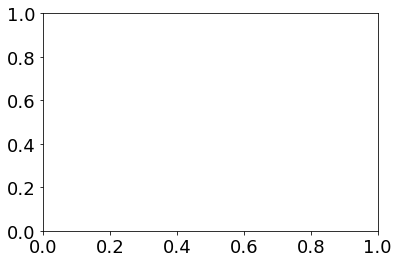

In [8]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax = dataDF.plot.scatter('D-B', 'C-A', c='Math Years', figsize=(10, 10), ax=ax)
ax.set_aspect('equal')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig('plot_results_{}.png'.format(version))